## Fitting PPXF to one mock - example notebook

This notebook exemplifies how to read one mock from the mini mocha challenge, using the GQP_MC tools, and fit it with PPXF using two simple templates. 

Notes:

 * The example fits to a noiseless spectra. Both templates and the noiseless spectra were constructed with the same SPS library (BC03/stelib), so we don't worry about instrumental mismatch of LSF. 
 * We use two sets of templates here, as input to PPXF 
     * A set of two simple templates, each with a complex SFH: one a bulge-like component, and one a disk-like component (described here: https://desi.lbl.gov/trac/wiki/GalaxiesWG/spectral_challenge#Simplemocks)
     * A set of 6 SSPs, with 3 different ages and 2 different metallicities
     
     
 * The example here fits one kinematic component, but ppxf can fit multiple kinematic components - each associated to a single template, or a set of templates (Aside: the LGal mocks have two - as bulge and disk are assumed to have different values of velocity dispersion)
 
 * Lots of very useful examples on how to run PPXF are provided with the installation (the first cell should output your installation location for ppxf)

 * In this notebook we don't fit DESI-like mocks, with the 3 different arms, only noiseless spectra where the instrumental LSF is the same between the templates and the mocks. At the end of the notebook we show how you can access the LSF of each of the 3 spectrographs from specsim, which you can use to fit the DESI BGS mocks made for the GQP mock challenge. But note that in real data what we get is a full resolution matrix (rather than an RMS per wavelength). There is a different notebook that shows how to run ppxf in Andes SV data.

* For some reason, np.pad() on the numpy version that I'm running, insists on the keyword 'mode' being set. If, when running ppxf, it hangs because of that, just edit the two lines in ppxf.py that use np.pad() and add mode='constant' to the np.pad() command.


In [24]:
import sys 
import os 
import h5py 
import numpy as np 
from astropy.io import fits
from scipy.io.idl import readsav
import imp

# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
# --- gqp_mc ---
from gqp_mc import util as UT 
from gqp_mc import data as Data 
#from gqp_mc import fitters as Fitters

sys.path.append("/global/homes/r/rtojeiro/desi_gqp/code/")
import desi_gqp_utils as my_utils

import fsps

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import glob
from time import perf_counter as clock

ppxf_dir = os.path.dirname(os.path.realpath(ppxf_package.__file__))
print("ppxf installed here: ", ppxf_dir)

from platform import python_version
print("python version: ", python_version())

ppxf installed here:  /global/u2/r/rtojeiro/mydesi/lib/python3.6/site-packages/ppxf
python version:  3.6.6


We'll define some functions to use later on

In [2]:
import specsim

## Reading and displaying spectra from the mock challenge

Reading the (mock) data, using the tools provided by gqp_mc

For noiseless templates (note, the meta data is the same for the noiseless and BGS mocks)

In [3]:
spec_s, meta = Data.Spectra(noise='none', sample='mini_mocha') #noiseless spectra 

print(spec_s.keys())
print(meta.keys())

dict_keys(['frac_fiber', 'wave', 'flux', 'flux_unscaled'])
dict_keys(['galid', 't_lookback', 'sfh_disk', 'sfh_bulge', 'Z_disk', 'Z_bulge', 'logM_disk', 'logM_bulge', 'logM_total', 't_age_MW', 'Z_MW', 'redshift', 'cosi', 'tau_ism', 'tau_bc', 'vd_disk', 'vd_bulge', 'logM_fiber', 'airmass', 'moon_alt', 'moon_ill', 'moon_sep', 'seeing', 'sun_alt', 'sun_sep', 'texp_total', 'transp', 'wave_sky', 'sbright_sky', 'sfr_1gyr', 'sfr_100myr'])


This is the assumed relationship between velocity dispersion and bulge mass in the mocks

Text(0,0.5,'vel dispersion bulge [km/s]')

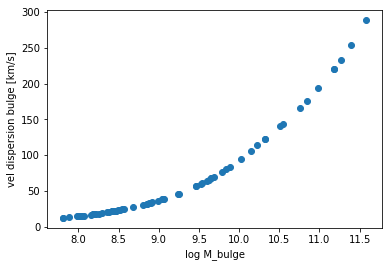

In [4]:
plt.scatter(meta['logM_bulge'], meta['vd_bulge'])
plt.xlabel('log M_bulge')
plt.ylabel('vel dispersion bulge [km/s]')

Pick a galaxy with a large velocity dispersion to make things easy to start with

In [5]:
g = np.where(meta['vd_bulge'] > 200)[0][0] #galaxy number to look at
z = meta['redshift'][g]
vdisp_bulge = meta['vd_bulge'][g]
vdisp_disk = meta['vd_disk'][g]
print('galaxy #' + str(g) + ' is at redshift ' + str(z) + ' with vel disp for bulge and disk of ' + str(vdisp_bulge) + ' and ' + str(vdisp_disk))

galaxy #35 is at redshift 0.3653412 with vel disp for bulge and disk of 253.4563457408788 and 50.0


In [6]:
#the wavelength and flux vectors
wave = spec_s['wave'][0]/(1 + z) #rest-frame wavelength
flux_gal = spec_s['flux'][g]
print(len(flux_gal))

985001


Text(0,0.5,'Flux')

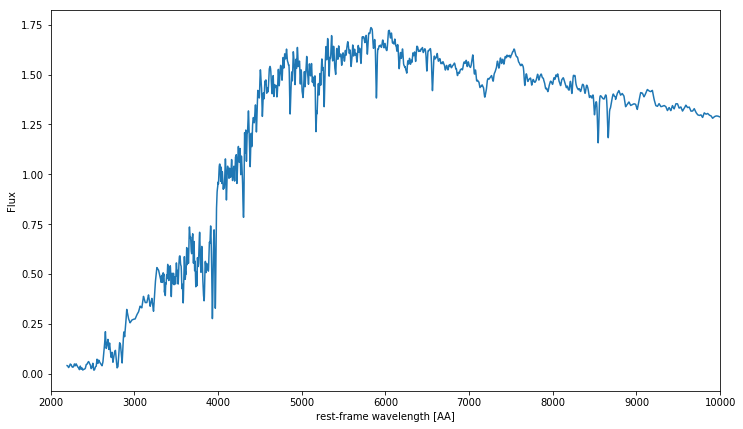

In [7]:
plt.figure(figsize=(12,7))
plt.plot(wave, flux_gal)
plt.xlim(2000,10000)
plt.xlabel('rest-frame wavelength [AA]')
plt.ylabel('Flux')

For DESI mocks, we get the wavelength and flux of each arm individually - we won't run these through ppxf in this notebook

In [8]:
wave_b, wave_r, wave_z, flux_b, flux_r, flux_z, _ = my_utils.read_BSG_mocks(noise='bgs6', sample='mini_mocha') #noise, conditions set number 6

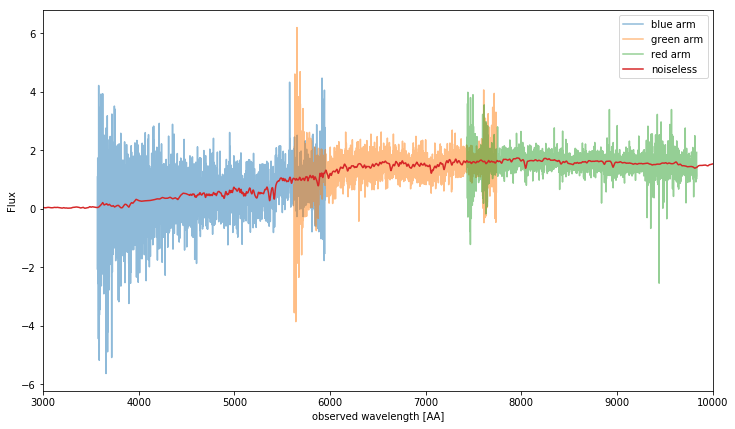

In [9]:
#plotting the flux from the 3 arms in the same plot, and the noiseless flux over

plt.figure(figsize=(12,7))

plt.plot(wave_b, flux_b[g], label='blue arm', alpha=0.5)
plt.plot(wave_r, flux_r[g], label = 'green arm', alpha=0.5)
plt.plot(wave_z, flux_z[g], label='red arm', alpha=0.5)

plt.plot(spec_s['wave'][0], spec_s['flux'][g], label='noiseless')

plt.xlim(3000, 10000)
plt.xlabel('observed wavelength [AA]')
plt.ylabel('Flux')
plt.legend()

In [10]:
wave[0]

2197.2529650463925

## running ppxf in the noiseless templates

From here on, the examples are on the noiseless templates only

Interpolate the spectrum to a common grid. We'll do this to the models, too.

In [11]:
#set up an overall wavelength range limit
wave_i = 3500
wave_f = 6500
lam_bounds = [wave_i, wave_f]

In [12]:
wave_gal,flux_gal = my_utils.to_common_grid(wave, flux_gal, wave_i, wave_f) #snaps back to BC03 original grid, because noiseless 
                                                            #templates were interpolated onto a dense grid
#re-define lambda range to the exact starting and ending values
lamrange= [wave_gal[0], wave_gal[-1]]
print(lamrange, np.shape(wave_gal),np.shape(flux_gal))

[3500.0, 6500.0] (3001,) (3001,)


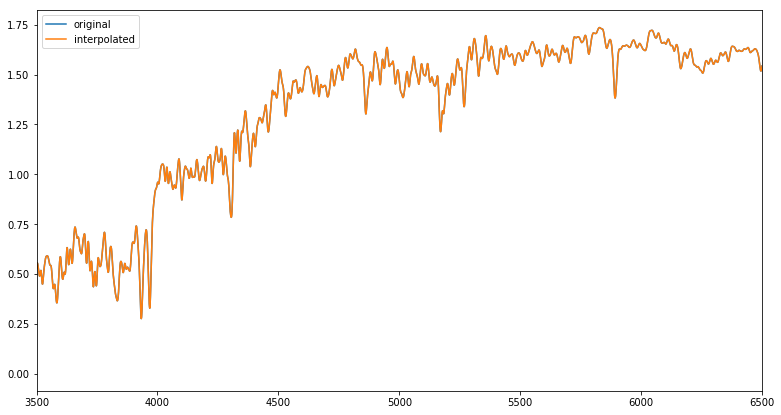

In [13]:
#a sanity check plot
plt.figure(figsize=(13,7))
plt.plot(spec_s['wave'][0]/(1+z), spec_s['flux'][g], label='original')
plt.plot(wave_gal, flux_gal, label='interpolated')
plt.xlim(wave_i,wave_f)
plt.legend()

Compute velocity scale and rebin in log_lambda, as required by ppxf

In [14]:
c = 299792.458                  # speed of light in km/s
frac = wave_gal[1]/wave_gal[0]  # Constant lambda fraction per pixel
velscale = np.log(frac)*c       # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
print('velocity scale = ', velscale)

velocity scale =  85.65186349364171


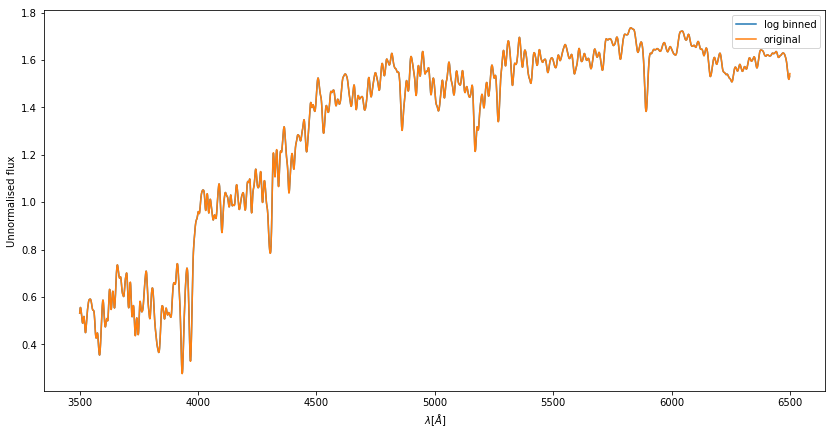

In [15]:
galaxy, logLam_gal, velscale = util.log_rebin(lamrange, flux_gal, velscale=velscale)

#plot original and rebinned spectra to make sure they match
plt.figure(figsize=(14,7))
plt.plot(np.exp(1)**logLam_gal, galaxy, label='log binned')
plt.plot(wave_gal, flux_gal, label='original')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('Unnormalised flux')
plt.legend()

#working vectors now are galaxy and lam_log both rebinned in equal bins in log_lambda
lam_gal = np.exp(1)**logLam_gal

In [16]:
len(logLam_gal)

2167

Read templates. The read_simple_templates() function already puts them in a common grid in log lambda

85.65186349364171 85.65186349364171
85.65186349364171


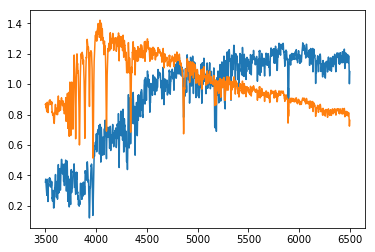

In [17]:
(loglam_temp, templates_simple) = my_utils.read_simple_templates(velscale,[wave_i, wave_f])
lam_temp = np.exp(1)**loglam_temp
lamRange_temp = [np.exp(1)**loglam_temp[0],np.exp(1)**loglam_temp[-1]]
print(velscale)

In [18]:
#sanity checks - these should all match
print(lam_temp[0],lam_gal[0])
print(lam_temp[-1],lam_gal[-1])
print(np.shape(lam_temp), np.shape(lam_gal))

3499.9999460434046 3499.9999460434046
6498.669875243832 6498.669875243832
(2167,) (2167,)


Alternative templates: in this case a grid of 3 ages at two metallicities

In [22]:
ages = np.array([0.1, 1, 10]) #in Gyrs
Z = np.array([0.001, 0.02])#metallicity between 0.0001 and 0.05 (fraction of metals by mass, Z_solar~0.02)

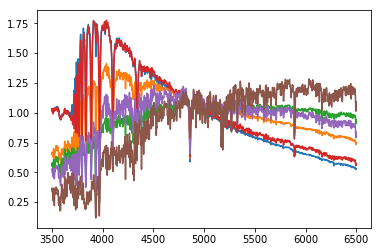

In [26]:
#this is for BC03 templates
imp.reload(my_utils)
loglam_temp_ssp, templates_ssp = my_utils.make_ssp_templates_bc03(velscale,lam_bounds, ages, Z)

In [27]:
#Lifted straight out of the ppxf examples. Note dv should be zero here as we're working on a fixed grid.

# The galaxy and the template spectra do not have the same starting wavelength.
# For this reason an extra velocity shift DV has to be applied to the template
# to fit the galaxy spectrum. We remove this artificial shift by using the
# keyword VSYST in the call to PPXF below, so that all velocities are
# measured with respect to DV. This assume the redshift is negligible.
# In the case of a high-redshift galaxy one should de-redshift its
# wavelength to the rest frame before using the line below (see above).
#
c = 299792.458   # km/s
dv = c*np.log(lam_temp[0]/lam_gal[0])    # eq.(8) of Cappellari (2017)
print(dv)
goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z)



0.0


[0, 200.0]
Best Fit:       Vel     sigma
 comp. 0:        35       225
chi2/DOF: 0.0003516
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
Nonzero (>0.1%) Templates: 2 / 2
Templates weights:
      1.26    0.0708
Formal errors:
     dV    dsigma   dh3      dh4
     2.2     2.3
Elapsed time in PPXF: 0.58 s


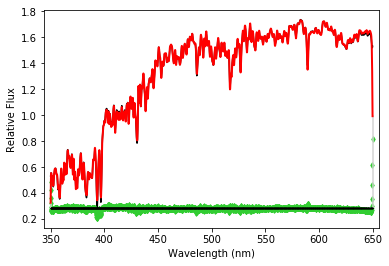

In [28]:
#Ditto.

# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [0, 200.]  # (km/s), starting guess for [V, sigma]
print(start)
noise=np.ones_like(galaxy)
t = clock()

pp = ppxf(templates_simple, galaxy,noise, velscale, start,plot=True, \
          moments=2, degree=4, vsyst=dv, clean=False, lam=lam_gal)

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in PPXF: %.2f s' % (clock() - t))

Best Fit:       Vel     sigma
 comp. 0:        36       224
chi2/DOF: 0.000337
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
Nonzero (>0.1%) Templates: 3 / 6
Templates weights:
  5.55e-17  2.91e-16     0.052 -5.55e-17     0.127      1.17
Formal errors:
     dV    dsigma   dh3      dh4
     2.1     2.3
Elapsed time in PPXF: 2.93 s


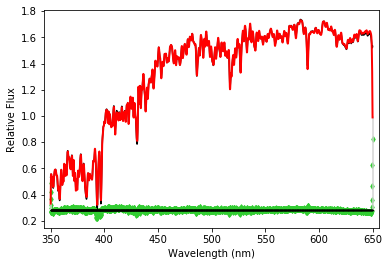

In [29]:
pp = ppxf(templates_ssp, galaxy,noise, velscale, start,plot=True, \
          moments=2, degree=4, vsyst=dv, clean=False, lam=lam_gal)

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in PPXF: %.2f s' % (clock() - t))

## Getting the RMS dispersion for the DESI spectrographs from specsim

You will want to use these if you're fitting template models that were constructed with a different spectral library than the mock galaxies. That is not what we did here.

In [3]:
import specsim.config
import specsim.instrument

In [4]:
#load DESI spectrographs configuration
config = specsim.config.load_config('desi')

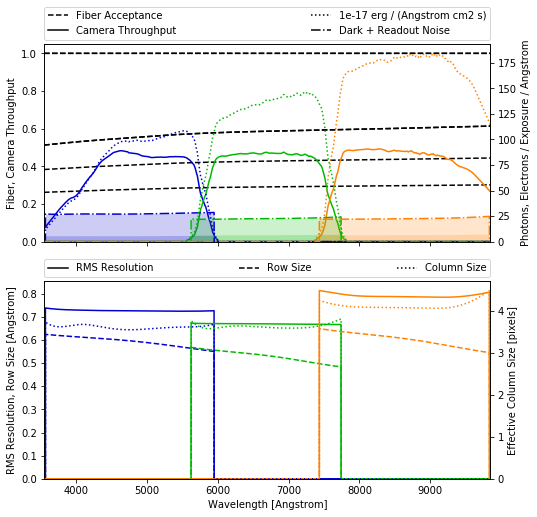

In [5]:
#summary plot of technical specs. we are interested in the RMS resolution 
specsim.instrument.initialize(config).plot()

In [6]:
#to access those values directly, for each of the arms:
instrument = specsim.instrument.initialize(config)
    
wavelength_blue = instrument.cameras[0]._wavelength 
rms_res_blue = instrument.cameras[0].rms_resolution.to(instrument._wavelength.unit).value

wavelength_green = instrument.cameras[1]._wavelength 
rms_res_green = instrument.cameras[1].rms_resolution.to(instrument._wavelength.unit).value

wavelength_red = instrument.cameras[2]._wavelength
rms_res_red = instrument.cameras[2].rms_resolution.to(instrument._wavelength.unit).value


Text(0,0.5,'RMS resolution')

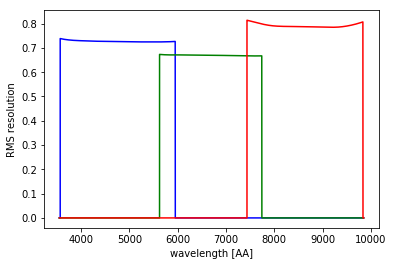

In [7]:
plt.plot(wavelength_blue,rms_res_blue, color='blue')
plt.plot(wavelength_green,rms_res_green, color='green')
plt.plot(wavelength_red,rms_res_red, color='red')
plt.xlabel('wavelength [AA]')
plt.ylabel('RMS resolution')

In [8]:
print('blue arm goes between ' + str(wavelength_blue[rms_res_blue > 0][0]) + ' and ' + str(wavelength_blue[rms_res_blue > 0][-1]) + 'AA')
print('green arm goes between ' + str(wavelength_green[rms_res_green > 0][0]) + ' and ' + str(wavelength_green[rms_res_green > 0][-1]) + 'AA')
print('red arm goes between ' + str(wavelength_red[rms_res_red > 0][0]) + ' and ' + str(wavelength_red[rms_res_red > 0][-1]) + 'AA')

blue arm goes between 3569.0 and 5949.0AA
green arm goes between 5625.0 and 7741.0AA
red arm goes between 7435.0 and 9834.0AA
